# Active Inference cadCAD model

This notebook explores active inference agent modeling in arbitrarily large grid worlds.

## Developing Active Inference Agents in cadCAD

An active inference agent consists of the following matrices:
- $A$ -> $P(o|s)$ the generative model's prior beliefs about how hidden states relate to observations
- $B$ -> $𝑃(𝑠_𝑡∣𝑠_{𝑡−1},𝑢_{𝑡−1})$ the generative model's prior beliefs about controllable transitions between hidden states over time
- $C$ -> $P(o)$ the biased generative model's prior preference for particular observations encoded in terms of probabilities
- $D$ -> $P(s)$ the generative model's prior belief over hidden states at the first timestep
- $E$ -> agent's affordances (in this notebook referred to as 'actions')

## cadCAD Standard Notebook Layout

### 0. Dependencies

In [14]:
!pip install inferactively-pymdp

In [4]:
import pandas as pd
import numpy as np
from random import normalvariate, random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(0, '../../')

from radcad import Model, Simulation, Experiment


# Additional dependencies
from pymdp.control import construct_policies
from pymdp.maths import softmax
import pymdp.utils as utils

# For analytics
import itertools

# For visualization
import plotly.express as px

# local utils
import blockference.utils.utils as u
from blockference.agent import Agent
from blockference.envs.grid_env import GridAgent
# from blockference.gridference import ActiveGridference

### 0. Setup

In [5]:
env = GridAgent(grid_len=10, num_agents=1, grid_dim=2)

In [6]:
A = np.eye(env.n_observations, env.n_states)

In [7]:
E = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [8]:
B = np.zeros((len(env.grid), len(env.grid), len(E)))

for action_id, action_label in enumerate(E):

    for curr_state, grid_location in enumerate(env.grid):

        y, x = grid_location

        if action_label == "UP":
            next_y = y - 1 if y > 0 else y
            next_x = x
        elif action_label == "DOWN":
            next_y = y + 1 if y < env.border else y
            next_x = x
        elif action_label == "LEFT":
            next_x = x - 1 if x > 0 else x
            next_y = y
        elif action_label == "RIGHT":
            next_x = x + 1 if x < env.border else x
            next_y = y
        elif action_label == "STAY":
            next_x = x
            next_y = y
        new_location = (next_y, next_x)
        next_state = env.grid.index(new_location)
        B[next_state, curr_state, action_id] = 1.0

In [9]:
preferred_state = (9, 3)
C = utils.onehot(env.grid.index(preferred_state), env.n_observations)

In [10]:
initial_state = (0, 0)
D = utils.onehot(env.grid.index(initial_state), env.n_states)
prior = D

In [11]:
policies = construct_policies([env.n_states], [len(E)], policy_len=2)

In [12]:
act = Agent(A=A, B=B, policies=policies)

### 1. State Variables

In [16]:
initial_state = {
    'A': softmax(act.A[0]),
    'B': act.B[0],
    'C': C,
    'prior': softmax(D),
    'env_state': env.grid[0],
    'action': '',
    'current_inference': ''
}

### 2. System Parameters

In [17]:
params = {
}

### 3. Policy Functions

- `get_observation`
- `infer_states`
- `calc_efe`
- `calc_action_posterior`
- `sample_action`
- `calc_next_prior`
- `update_env_state`

In [18]:
u.infer_states

<function blockference.utils.utils.infer_states(observation_index, A, prior)>

In [25]:
def p_actinf(params, substep, state_history, previous_state):
    # get obs_idx
    obs_idx = env.grid.index(previous_state['env_state'])

    # infer_states
    qs_current = u.infer_states(obs_idx, previous_state['A'], previous_state['prior'])

    # calc efe
    G = u.calculate_G_policies(previous_state['A'], previous_state['B'], previous_state['C'], qs_current, policies=policies)

    # calc action posterior
    Q_pi = u.softmax(-G)

    # compute the probability of each action
    P_u = u.compute_prob_actions(act.E, policies, Q_pi)

    # sample action
    chosen_action = u.sample(P_u)

    # calc next prior
    prior = previous_state['B'][:,:,chosen_action].dot(qs_current) 

    # update env state
    # action_label = params['actions'][chosen_action]

    (Y, X) = previous_state['env_state']
    Y_new = Y
    X_new = X

    if chosen_action == 0: # UP
          
        Y_new = Y - 1 if Y > 0 else Y
        X_new = X

    elif chosen_action == 1: # DOWN

        Y_new = Y + 1 if Y < env.border else Y
        X_new = X

    elif chosen_action == 2: # LEFT
        Y_new = Y
        X_new = X - 1 if X > 0 else X

    elif chosen_action == 3: # RIGHT
        Y_new = Y
        X_new = X +1 if X < env.border else X

    elif chosen_action == 4: # STAY
        Y_new, X_new = Y, X 
        
    current_state = (Y_new, X_new) # store the new grid location

    return {'update_prior': prior,
            'update_env': current_state,
            'update_action': chosen_action,
            'update_inference': qs_current}

### 4. State Update Functions

In [26]:
def s_prior(params, substep, state_history, previous_state, policy_input):
    updated_prior = policy_input['update_prior']
    return 'prior', updated_prior

def s_env(params, substep, state_history, previous_state, policy_input):
    updated_env_state = policy_input['update_env']
    return 'env_state', updated_env_state

def s_action(params, substep, state_history, previous_state, policy_input):
    return 'action', policy_input['update_action']

def s_qs(params, substep, state_history, previous_state, policy_input):
    return 'current_inference', policy_input['update_inference']

### 5. Partial State Update Blocks

In [27]:
state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'prior': s_prior,
            'env_state': s_env,
            'action': s_action,
            'current_inference': s_qs
        }
    }
]

### 6. Configuration

In [28]:
model = Model(
    # Model initial state
    initial_state=initial_state,
    # Model Partial State Update Blocks
    state_update_blocks=state_update_blocks,
    # System Parameters
    params=params
)

### 7. Execution

In [29]:
simulation = Simulation(
    model=model,
    timesteps=100,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)

In [30]:
result = simulation.run()

### 8. Analysis

In [31]:
df = pd.DataFrame(result)
df

,A,B,C,prior,env_state,action,current_inference,simulation,subset,run,substep,timestep
0,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02672363098939523, 0.009831074434450556, 0....","(0, 0)",,,0,0,1,0,0
1,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0694531596563796, 0.00939946303377394, 0.00...","(0, 0)",4,"[0.0694531596563796, 0.00939946303377394, 0.00...",0,0,1,1,1
2,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.16866478870681606, 0.008397325366597817, 0....","(0, 0)",4,"[0.16866478870681606, 0.008397325366597817, 0....",0,0,1,1,2
3,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3619714822160643, 0.013020990158855826, 0.0...","(0, 0)",0,"[0.3554609871366364, 0.006510495079427913, 0.0...",0,0,1,1,3
4,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6146612421088251, 0.008027890789399417, 0.0...","(0, 0)",2,"[0.6066333513194258, 0.008027890789399417, 0.0...",0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
96,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.385500076446749e-17, 5.032147244080568...","(3, 9)",3,"[6.385500076446749e-17, 5.032147244080568e-17,...",0,0,1,1,96
97,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.357588823428889e-17, 1.2918875980943952e-16...","(2, 9)",0,"[3.6787944117144447e-17, 6.027888611437916e-17...",0,0,1,1,97
98,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.1417647320527316e-16, 1.4539917064444794e-1...","(1, 9)",0,"[6.385500076446749e-17, 8.431383288147303e-17,...",0,0,1,1,98
99,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2, 9)",1,"[7.879112127482669e-17, 9.027730976061534e-17,...",0,0,1,1,99


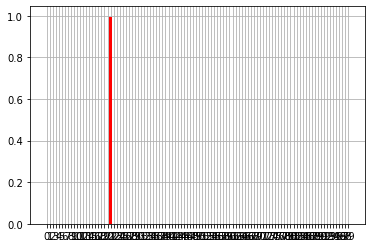

In [32]:
u.plot_beliefs(df['prior'][9])